In [1]:
from keras.models import Sequential
from keras.layers import Conv1D, LSTM,GRU,MaxPooling1D,Dropout,Activation,Embedding,RepeatVector,TimeDistributed,Conv2D,MaxPooling2D,Flatten,Convolution2D
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import time
from keras import metrics
from keras import optimizers
from keras import initializers
from keras.callbacks import ModelCheckpoint
import pprint
from keras.callbacks import Callback
from matplotlib import pyplot
from numpy import array

from sklearn import metrics
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import Normalizer
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

Using TensorFlow backend.
c:\users\kahraman\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\kahraman\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\kahraman\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [2]:
df = pd.read_csv('h_train_sm.csv',header=None )
np.random.seed(42)
df.head()


X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data
X.shape

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.0,1.0,...,0.0,0.0,4.0,0.0,1.0,3.0,45.0,1.0,1.521928,Aria
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.0,1.0,...,0.0,0.0,4.0,0.0,1.0,3.0,40.0,0.0,0.000000,Aria
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.0,0.0,1.0,1.0,328.0,0.0,0.000000,Aria
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,4.0,0.0,1.0,1.0,328.0,0.0,0.000000,Aria
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,3.0,0.0,3.0,1.0,60.0,0.0,0.000000,Aria


In [3]:

X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data
X.shape

(270000, 25)

In [4]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [5]:
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)


In [6]:
y

array([ 0,  0,  0, ..., 26, 26, 26])

In [7]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)

In [8]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [9]:
#Train test validation split - 60:20:20
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state=42)


In [10]:
X_train.shape

(216000, 25)

In [11]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train,( X_train.shape[0], 5, 5))
X_val = np.reshape(X_val,( X_val.shape[0], 5, 5))

In [12]:
# reshape input to be [samples, time steps, features]
Y_train = np.reshape(Y_train, (Y_train.shape[0],  Y_train.shape[1]))
Y_val = np.reshape(Y_val, (Y_val.shape[0],  Y_val.shape[1]))

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [14]:
X_train.shape

(216000, 5, 5)

In [15]:
# Embedding
max_features = X_train[0]
maxlen = 25
embedding_size = 50

# Convolution
kernel_size = 5
filters = 128
pool_size = 4

# LSTM
lstm_output_size = 27
number_of_units=25
model_FileName = "long_mc_bestWeightsLSTMStateless3L50.hdf5"
Batch_size = 10
randomInit = initializers.RandomUniform(seed=42)
lr=0.002
Epochs=30
dropout=1
# Training
batch_size = 30
epochs = 20

In [16]:
model = Sequential()
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1,input_shape=(5, 5)))
model.add(MaxPooling1D(pool_size=pool_size, padding='same'))
model.add(GRU(number_of_units, kernel_initializer = randomInit, bias_initializer = randomInit,))
model.add(Dense(27))
model.add(Activation('softmax'))

nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])




hdf5FileName = "long_mc_bestWeightsLSTMStateless3L50.hdf5"
checkpoint = ModelCheckpoint(hdf5FileName,monitor='val_acc',verbose=1,save_best_only=True,mode='max',save_weights_only=True)

start_time = time.time()



history=model.fit(X_train, Y_train, epochs=50, batch_size=100, verbose=2, shuffle=False,
            validation_data = (X_val,Y_val),callbacks=[checkpoint,es])  

print("--- %s seconds ---" % (time.time() - start_time))

from keras.models import load_model

model.save(hdf5FileName[:-3])  # creates a HDF5 file 'my_model.h5'



Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train on 216000 samples, validate on 54000 samples
Epoch 1/50
 - 10s - loss: 2.6950 - acc: 0.1800 - val_loss: 2.4139 - val_acc: 0.2550

Epoch 00001: val_acc improved from -inf to 0.25496, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 2/50
 - 9s - loss: 2.2970 - acc: 0.2725 - val_loss: 2.2012 - val_acc: 0.2913

Epoch 00002: val_acc improved from 0.25496 to 0.29126, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 3/50
 - 8s - loss: 2.1298 - acc: 0.3127 - val_loss: 2.0566 - val_acc: 0.3259

Epoch 00003: val_acc improved from 0.29126 to 0.32589, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 4/50
 - 7s - loss: 1.9935 - acc: 0.3552 - val_loss: 1.9332 - val_acc: 0.3667

Epoch 00004: val_acc improved from 0.32589 to 0.36674, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 5/50
 - 8s - loss: 1.8754 - acc: 0.3853 - val_loss: 1.8153 - val_acc: 0.39

 - 11s - loss: 1.0578 - acc: 0.6045 - val_loss: 1.0563 - val_acc: 0.6041

Epoch 00042: val_acc improved from 0.59726 to 0.60406, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 43/50
 - 11s - loss: 1.0541 - acc: 0.6056 - val_loss: 1.0520 - val_acc: 0.6021

Epoch 00043: val_acc did not improve
Epoch 44/50
 - 11s - loss: 1.0504 - acc: 0.6066 - val_loss: 1.0480 - val_acc: 0.6066

Epoch 00044: val_acc improved from 0.60406 to 0.60656, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 45/50
 - 11s - loss: 1.0468 - acc: 0.6078 - val_loss: 1.0449 - val_acc: 0.6064

Epoch 00045: val_acc did not improve
Epoch 46/50
 - 10s - loss: 1.0435 - acc: 0.6091 - val_loss: 1.0412 - val_acc: 0.6092

Epoch 00046: val_acc improved from 0.60656 to 0.60922, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 47/50
 - 10s - loss: 1.0401 - acc: 0.6097 - val_loss: 1.0380 - val_acc: 0.6090

Epoch 00047: val_acc did not improve
Epoch 48/50
 - 11s - loss: 1.0372 - acc: 0.610

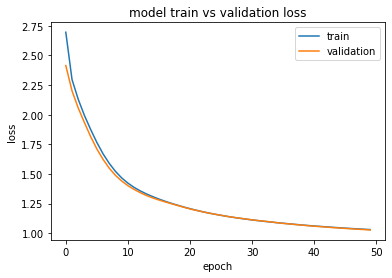

In [17]:

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')




pyplot.show()

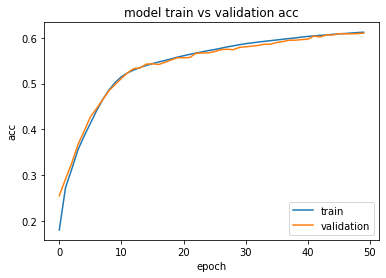

In [18]:

pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation acc')
pyplot.ylabel('acc')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()

## Test

In [20]:
df = pd.read_csv('h_test_sk.csv',header=None )
np.random.seed(42)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,40,0,0.000000,Aria
1,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,765,1,5.567481,Aria
2,0,0,0,1,0,0,1,0,29200,1,...,0,0,4,0,1,2,48,0,0.000000,Aria
3,1,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0.000000,Aria
4,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,40,0,0.000000,Aria


In [21]:
## 
X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data



from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)



from keras.utils import np_utils
y = np_utils.to_categorical(y)


# reshape input to be [samples, time steps, features]
X_test = np.reshape(X, (X.shape[0], 1, X.shape[1]))



# reshape input to be [samples, time steps, features]
Y_test = np.reshape(y, (y.shape[0],  y.shape[1]))



# reshape input to be [samples, time steps, features]
X_test = np.reshape(X_test,( X_test.shape[0], 5, 5))


In [22]:
Y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

## TEST DEĞERLENDİRME

In [23]:
loss,acc = model.evaluate(X_test,Y_test,batch_size=1)
print("Loss for testing = {} and Accuracy for testing = {}".format(loss,acc))
#predicted = model.predict(X_test)

81000/81000 [==============================] - 120s 1ms/step
Loss for testing = 1.0924746682907205 and Accuracy for testing = 0.5979382716049383


In [24]:
predicted = model.predict(X_test)



In [25]:
predicted

array([[9.9775451e-01, 6.2918692e-09, 1.4830516e-17, ..., 6.6704742e-18,
        2.5740211e-12, 2.1571368e-03],
       [9.7727668e-01, 3.0567998e-04, 2.4860080e-07, ..., 3.7334251e-14,
        5.2247590e-10, 7.3814800e-04],
       [7.9028890e-02, 5.0365226e-04, 7.8251858e-09, ..., 5.3211246e-03,
        3.8712083e-03, 3.3157703e-01],
       ...,
       [5.4067999e-01, 1.9299269e-04, 1.2247212e-10, ..., 1.4838421e-04,
        1.0305216e-02, 3.1011102e-01],
       [4.4627437e-01, 1.7364546e-04, 4.6861354e-10, ..., 7.0651602e-08,
        2.1977758e-07, 9.6952207e-02],
       [5.4077530e-01, 1.9262773e-04, 1.2245353e-10, ..., 1.4829307e-04,
        1.0303303e-02, 3.1002489e-01]], dtype=float32)

In [26]:
(X_test.shape)

(81000, 5, 5)

In [27]:
#predicted = model.predict(X_test)

In [28]:
(predicted.shape)

(81000, 27)

In [29]:
"""

for i in X_test:
    temp=i
    print(temp.shape) #(predicted)
    temp=(np.reshape(temp, (temp.shape[0], 1, temp.shape[1])))
    print(temp.shape) #(predicted)
    predicted = model.predict(temp,batch_size=1000)
    print(predicted)
    break
"""

'\n\nfor i in X_test:\n    temp=i\n    print(temp.shape) #(predicted)\n    temp=(np.reshape(temp, (temp.shape[0], 1, temp.shape[1])))\n    print(temp.shape) #(predicted)\n    predicted = model.predict(temp,batch_size=1000)\n    print(predicted)\n    break\n'

### grafik mırafik

In [30]:
def compute_metrics(predicted, Y_test):   
    Y_classes = [np.argmax(item) for item in Y_test]
    #print(Y_classes)
    predicted_classes = [np.argmax(item) for item in predicted]
    predictions = np.array(predicted_classes)
    Y_actual = np.array(Y_classes)
   
    y_actu = pd.Series(np.reshape(Y_actual,len(Y_actual)), name='Actual')
    y_pred = pd.Series(np.reshape(predictions, len(predictions)), name='Predicted')
    
    y_act = pd.Categorical(y_actu, categories=list(range(0,27)))
    y_pre = pd.Categorical(y_pred, categories=list(range(0,27)))
    
    #F1 score
    from sklearn.metrics import f1_score
    print("Average F1 score is {}".format(f1_score(Y_classes, predicted_classes, average='weighted', labels = list(range(0,27)))))
    
    df_confusion = pd.crosstab(y_act, y_pre, rownames =['Actual'],colnames=['Predicted'])
    print("Confusion matrix: \n", df_confusion)
    #pprint.pprint(df_confusion)
    
    predicted= np.array(predicted).tolist()
    Y_test = np.array(Y_test).tolist()

    n_classes = 27
    print("n_classes is: ", n_classes)
    Y_test= np.asarray(Y_test)
    predicted = np.asarray(predicted)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    lw = 2
    # Compute macro-average ROC curve and ROC area
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [31]:
predicted

array([[9.9775451e-01, 6.2918692e-09, 1.4830516e-17, ..., 6.6704742e-18,
        2.5740211e-12, 2.1571368e-03],
       [9.7727668e-01, 3.0567998e-04, 2.4860080e-07, ..., 3.7334251e-14,
        5.2247590e-10, 7.3814800e-04],
       [7.9028890e-02, 5.0365226e-04, 7.8251858e-09, ..., 5.3211246e-03,
        3.8712083e-03, 3.3157703e-01],
       ...,
       [5.4067999e-01, 1.9299269e-04, 1.2247212e-10, ..., 1.4838421e-04,
        1.0305216e-02, 3.1011102e-01],
       [4.4627437e-01, 1.7364546e-04, 4.6861354e-10, ..., 7.0651602e-08,
        2.1977758e-07, 9.6952207e-02],
       [5.4077530e-01, 1.9262773e-04, 1.2245353e-10, ..., 1.4829307e-04,
        1.0303303e-02, 3.1002489e-01]], dtype=float32)

In [32]:
print(predicted.shape, Y_test.shape)

(81000, 27) (81000, 27)


Average F1 score is 0.5927406087476319
Confusion matrix: 
 Predicted    0     1     2     3     4    5    6    7    8     9   ...    17  \
Actual                                                             ...         
0          2254     0     0     0     0    0    0    0    0     0  ...   263   
1             1  2167    81     0     5  164  127   81  111    42  ...    18   
2            19    43  2193     0     0    0    0    0    0   479  ...     0   
3            32    58    40  2773     0    0    0    0   18    21  ...     0   
4             4   148     5     0  1656  141   58  513   75     0  ...    11   
5            22   173    13     0   250  619  184  844  571    16  ...    12   
6             5   159    15     0   190  486  322  909  606    16  ...     8   
7             3   122     0     0   469  349  373  514  868    21  ...     4   
8             7   233    15     0   233  571  216  806  612    12  ...     2   
9            41    32   304     0     0    0    0    0    0  

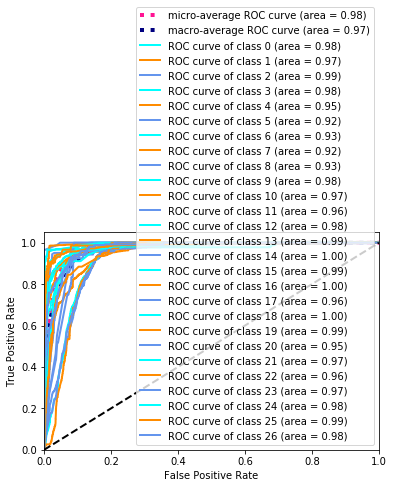

In [33]:
compute_metrics(predicted, Y_test)

In [34]:
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))

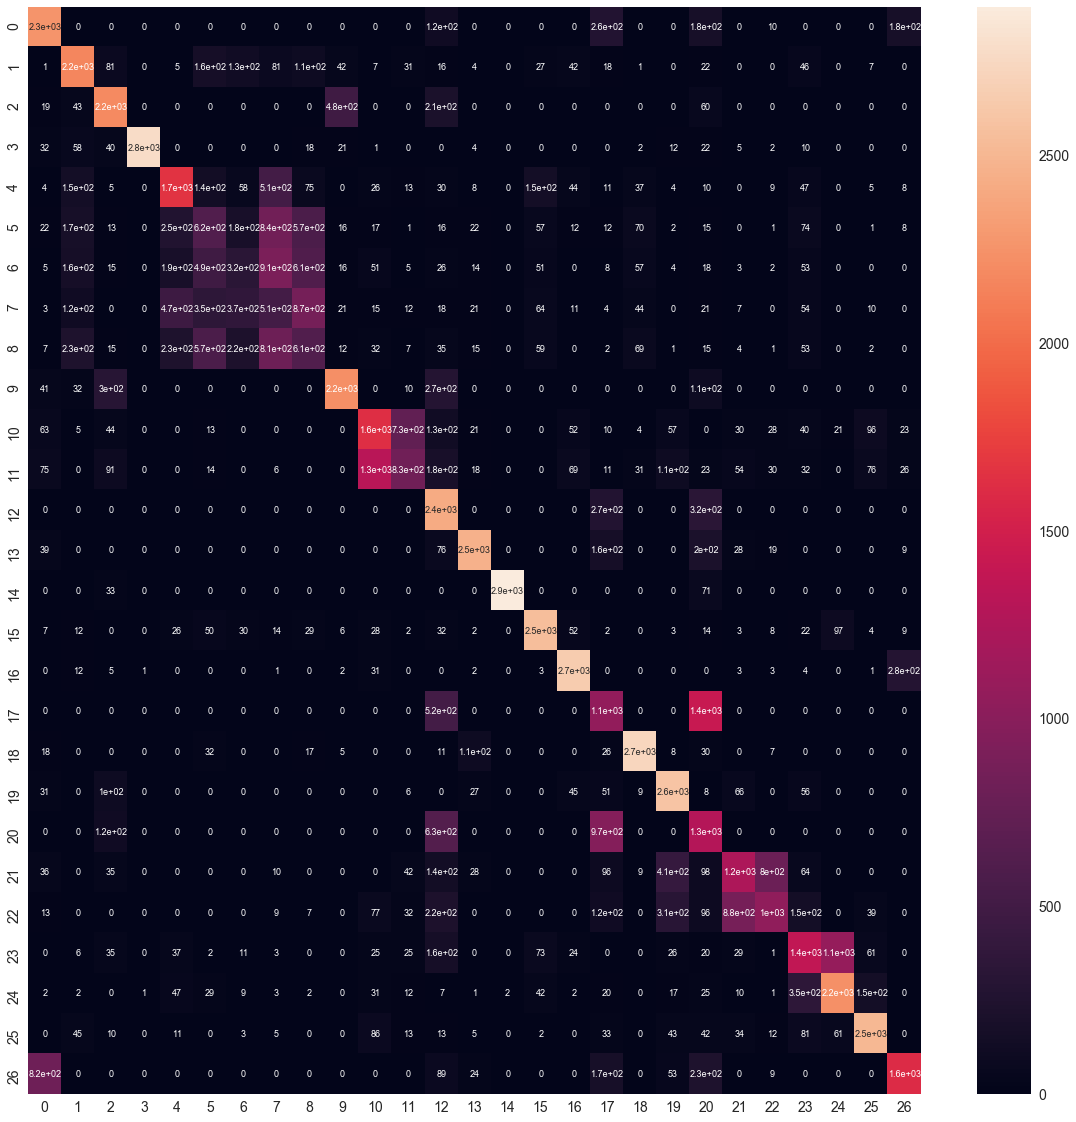

In [35]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt



df_cm = pd.DataFrame(matrix, range(27), range(27))
plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size

plt.show()

In [36]:
cm=matrix
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

print("label precision recall fscore")
for label in range(27):
    pr=precision(label, cm)
    rec=recall(label, cm)
    f1=2*(pr*rec/(pr+rec))
    print(f"{label:5d} {pr:9.3f} {rec:6.3f} {f1:6.3f}")

label precision recall fscore
    0     0.646  0.751  0.695
    1     0.674  0.722  0.697
    2     0.697  0.731  0.714
    3     0.999  0.924  0.960
    4     0.566  0.552  0.559
    5     0.251  0.206  0.226
    6     0.242  0.107  0.149
    7     0.138  0.171  0.153
    8     0.210  0.204  0.207
    9     0.782  0.743  0.762
   10     0.482  0.542  0.510
   11     0.467  0.276  0.347
   12     0.450  0.805  0.577
   13     0.883  0.822  0.851
   14     0.999  0.965  0.982
   15     0.829  0.849  0.839
   16     0.883  0.885  0.884
   17     0.320  0.352  0.335
   18     0.891  0.911  0.901
   19     0.709  0.866  0.780
   20     0.293  0.426  0.348
   21     0.517  0.411  0.458
   22     0.527  0.350  0.420
   23     0.548  0.459  0.499
   24     0.640  0.746  0.689
   25     0.847  0.834  0.840
   26     0.747  0.533  0.622


## MODEL SAVING RELOADING

In [37]:
from keras.models import load_model

model.save('54.h5')  # creates a HDF5 file 'my_model.h5'



In [38]:

# returns a compiled model
# identical to the previous one
model = load_model('54.h5')